# 对未标记的数据进行预训练

In [1]:
from importlib.metadata import version   #检查本节所需要的库

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.2
numpy version: 1.26.4
tiktoken version: 0.8.0
torch version: 2.4.1
tensorflow version: 2.17.0


- 本节利用循环训练和基础评估模型来对一个LLM进行预训练
- 本节最后会将openai开源的预训练权重加载到模型中

## 1.评估产生的文本的模型
- 回顾先前写过的GPT模型
- 讨论分析最基础的LLMs评估矩阵
- 最后将这些评估矩阵应用到一个训练和检验的数据集中
### 1.1 使用GPT来产生文本
- 利用先前的代码来初始化一个GPT模型

In [3]:
import torch
from previous_chapters import GPTModel  #引入先前写的GPT模型

GPT_CONFIG_124M = {  #模型基础参数
    "vocab_size" : 50257,
    "context_length" : 256,
    "emb_dim" : 768,
    "n_heads" : 12,
    "n_layers" :12,
    "drop_rate" : 0.1,
    "qkv_bias" :False
    
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval() #评估的时候禁用dropout这些

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

- 我们使用0.1的dropout率，不过现在很多LLMs在训练的时候不使用dropout了。
- 先进的LLMs同样在线性层的时候不使用偏置向量 -- 通过设置 " qkv_bias " = False 来实现
- 本次降低了context_length 到256，而不是先前GPT2模型对应的1024 （为了体谅一下电脑的算力..）之后也可以通过改配置到1024继续操作。

In [30]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text,tokenizer):
    encoded = tokenizer.encode(text,allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) #加上批次的维度
    return encoded_tensor  #因为后续模型处理的是张量，而不是列表。分词其直接处理最后产生的是一个token id 的列表，所以要进行转化

def token_ids_to_text(token_ids,tokenizer):
    flat = token_ids.squeeze(0) #去除批次维度
    return tokenizer.decode(flat.tolist())    #将token ids 转化为文本，需要先去除批次，将所有文本权重位于第一的维度，再转化为列表，提供给decode方法使用

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2") #载入分词器

token_ids = generate_text_simple( #将处理模型，文本tokens ， 要生成的tokens数，文本大小
    model = model,
    idx = text_to_token_ids(start_context,tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

print("Output text:\n",token_ids_to_text(token_ids,tokenizer)) #将生成的tokens转化为文本

Output text:
 Every effort moves you know," was one of the picture for a smile


- 由于没有对模型进行训练，当前产生的文本质量较差。

<br>

### 1.2计算文本的损失函数 ： 交叉熵损失(cross-entropy) 和 混乱度(perplexity)

- 假定此时我们有一个2个样例的输入 同时有一个对应的target（即，已知的你要生成的内容）
- 注意由于input 和 target之间是由滑动窗口等实现的，所以两者的数据之间存在平移

In [216]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [217]:
with torch.no_grad():       #表示不影响模型的梯度
    logits = model(inputs)  #将输入作为参数，代入模型计算

probas = torch.softmax(logits,dim = -1)  #得到概率分布
print(probas.shape) #shape：(batch_size,nums_tokens,vocab_size)

torch.Size([2, 3, 50257])


- 按ch4结尾，使用argmax函数来处理概率分布。
- softmax 函数处理过后，每一个token会产生一个50257维度的子向量（概率分布），然后使用argmax函数，可以获得最高概率所在的位置，这就是下一个预测的token id

In [219]:
token_ids = torch.argmax(probas,dim = -1,keepdim = True)  #获得最高概率所在的位置
print("Token IDs:\n",token_ids) #形状为(batch_size,num_token,1)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [220]:
print(f"Targets batch 1: {token_ids_to_text(targets[0],tokenizer)}")  #输出理想的目标文本
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(),tokenizer)}") #输出通过模型处理所得的文本
#这里tokens_ids 的第一个批次形状是[[1][1][1]] / (num_tokens,1) -->所以用flatten先进行铺平，变为(num_tokens*1) 
# 发现两者并不相同

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


- 由于模型未训练，所以得到的结果与自己期待的结果相差很大。
- 训练的目的就是让输出值尽可能地接近我们想要的值
- 为了训练模型，我们需要知道它距离我们的期望到底有多远
- token

In [222]:
text_idx = 0
target_probas_1 = probas[text_idx,[0,1,2],targets[text_idx]] #提取第0号批次，012（即前三个元素），targets[0]对应的句子中 token对应的id
print("Text 1 : ",target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx,[0,1,2],targets[text_idx]]
print("Text 2 : ",target_probas_2)

Text 1 :  tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2 :  tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 我们的目标就是使得这些目标概率尽可能地接近1
- 通过最优化的方式，利用概率的对数进行运算比直接利用概率本身更便捷，但超出了本书的范围了 ，具体参考：[L8.2 Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM)

In [224]:
#计算所有概率的对数
log_probas = torch.log(torch.cat((target_probas_1,target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [225]:
#计算概率对数的平均值
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 目标是使得模型输出的概率尽可能地接近1 -- 即平均对数接近0 （取值范围为负无穷到0）
- 在深度学习中，并不是利用这些负值的最大值，而是先将他转化为正值，然后希望获得最小的正值 。这里正值为负概率对数，又称为交叉熵损失(cross entropy loss)，是最常用的损失函数

In [227]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- pytorch中已经实现了交叉熵函数(cross_entropy) 来实现上述功能
<br></br>
- 在应用交叉熵函数之前，先检查一下logits和targets的形状

In [229]:
# logits shape :(batch_size, num_tokens , vocab_size)
print("Logits shape :",logits.shape)

#Targets shape:(batch_size,num_tokens) 这里最后target直接对应的是token id，不需要一个词典向量
print("Targets shape:",targets.shape)

Logits shape : torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [230]:
#为使用cross_entropy函数，先将这些向量在batch_size 维度上进行摊平

logits_flat = logits.flatten(0,1) #从第0维开始展平，到第1维结束
targets_flat = targets.flatten() #将所有维度展平

print("Flattened logits:",logits_flat.shape)
print("Flattened targets:",targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- targets 对应的值即为token id ，同时它又代表着在logits 中我们想最大化的概率的索引
- 可以利用` corss_entropy`函数来直接求得交叉熵损失 

In [232]:
loss = torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(10.7940)


- LLM中一个和交叉熵损失相关的概念就是 混乱度(perplexity)
- 混乱度就是交叉熵损失的指数

In [234]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


- 混乱度可以被理解为当前模型不确定下一部到底是xxx个单词中的哪一个，这里了xxx就是上文的48725
- 也就是混乱度将概率分布，转化成了实际单词分布
- 和交叉熵损失一样，混乱度越小，越接近实际分布

### 1.3计算训练集和验证集损失

- 出于学习需求，成本和时间考虑，我们使用一个小的训练集进行训练。
- 使用我们在ch2 中使用过的小数据集

In [238]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path): #如果当前路径下不存在该文件
    with urllib.request.urlopen(url) as response: #从url中获取该文件，并将内容按utf-8的形式解码
        text_data = response.read().decode('utf-8') 
    with open(file_path,"w",encoding="utf-8") as file: #将刚刚解码得到的文本，写入该路径下名为"the-verdict.txt"的文件中
        file.write(text_data)
else:
    with open(file_path,"r",encoding= "utf-8") as file:
        text_data = file.read()

In [239]:
print(text_data[:99]) #通过输出前100和后100个字符来快速检验一下
print(text_data[-99:])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [240]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("characters:",total_characters)
print("tokens:",total_tokens)

characters: 20479
tokens: 5145


- 接下来，我们要将数据集分为训练集和验证集。并且使用ch2中写过的 数据加载器 为LLM训练提供一批一批的数据
- 大部分的输入文本会作为训练集使用，剩下小部分的则作为后续的验证集
- 先将文本进行分词 --> 将一个文本分成了大小为context_length 的块 -->然后按batchs再次分配（加上了shuffling，打乱数据）

In [242]:
from previous_chapters import create_dataloader_v1

train_ratio = 0.90 #区分开训练集train和验证集validation所占文本比例
split_idx = int(train_ratio*len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)

#分别利用训练集文本和验证集的文本，通过数据加载器，来获得所需训练/校验用的数据
train_loader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride =  GPT_CONFIG_124M["context_length"],
    drop_last = True,
    shuffle = True,
    num_workers = 0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride =  GPT_CONFIG_124M["context_length"],
    drop_last = True,
    shuffle = True,
    num_workers = 0
)

In [243]:
# 健全性检查
if total_tokens*(train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader."
          "Try to lower the `GPT_CONFIG_124M[context_length]` or "
          "increase the `training_ratio`"
         )
if total_tokens*(1 - train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader."
          "Try to lower the `GPT_CONFIG_124M[context_length]` or "
          "decrease the `training_ratio`"
         )

- 上述我们采用的batch 只有 2（考虑到计算机性能的需求），并且数据较小，容易处理
- 如果对于一些比较大的训练模型，一个可以选择的检查方法：

In [245]:
print("Train loader:")
for x,y in train_loader:
    print(x.shape,y.shape)

print("\nValization loader:")
for x,y in val_loader:
    print(x.shape,y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Valization loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 另一个可以选择的检查方法(计算数据大小，判断是否在预期范围内)：

In [247]:
train_tokens = 0
for input_batch,target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch,target_batch in val_loader:
    val_tokens +=input_batch.numel()

print("Training tokens:",train_tokens)
print("Validation tokens:",val_tokens)
print("All tokens:",train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- 接下来，我们要实现一个实用函数来计算单个批次的交叉熵损失
- 此外，还需要实现第二个实用函数来计算用户指定批次数目（在数据集中）的交叉熵损失

In [249]:
def calc_loss_batch(input_batch,target_batch,model,device):
    input_batch,target_batch = input_batch.to(device),target_batch.to(device) #将输入批次，目标批次转化到当前使用的设备上（cpu/gpu）
    logits = model(input_batch) #通过model模型，来获得概率分布前的数据(即再softmax一下就是概率分布)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten()) #计算交叉熵损失
    return loss

def calc_loss_loader(data_loader,model,device,num_batches=None):
    total_loss = 0. #用于存放总的损失
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)  #如果玩家没有自定义批次数目，则默认处理数据加载器中的所有批次
    else:
        num_batches = min(num_batches,len(data_loader)) #如果自定义的批次数目高于加载器中所有的数目，则减少至只处理加载器中有的数目
    for i,(input_batch,target_batch) in enumerate(data_loader):
        if i < num_batches: #只处理到num_batches数量的批次
            loss = calc_loss_batch(input_batch,target_batch,model,device) #获取当前批次的交叉熵损失
            total_loss += loss.item() #由于loss是一个张量（tensor），所以需要先提取出其中的数值标量
        else :
            break 
    return total_loss/num_batches #返回平均的交叉熵损失

- 通过设定 device ，确保LLM模型 数据都被加载到同一个设备上

In [251]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #如果电脑支持cuda GPU操作，则使用GPU，反之CPU

model.to(device) #不需要写 model = model.to(device) 这种重新赋值的方式。 因为 to 是进行的原地操作，不会返回值

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device)  #获取train训练集的交叉熵
    val_loss = calc_loss_loader(val_loader,model,device) #获取校验集的交叉熵

print("Training loss: ",train_loss)
print("Validation loss: ",val_loss)

Training loss:  10.98758347829183
Validation loss:  10.981106758117676


- 截止目前，已经实现了文本生成（利用GPT模型）
- 文本评估（利用交叉熵损失/混乱度）
- 分成训练集和校验集进行计算交叉熵损失


## 2.训练LLM

- 本节实现对LLM的训练代码。
- 目前下面实现的是一个简单的训练函数。如果需要更先进的工具，参考附件D

In [75]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):  #optimizer 是用于模型优化的优化器 ， num_epochs 是训练的轮次数 ，eval_freq 评估频率 ， eval_iter 评估中使用的批次数量

    #初始化列表，来追踪训练集损失，验证集损失，模型训练过程中已经处理过的token数量。
    train_losses, val_losses, track_tokens_seen = [], [], []
    #记录训练过程中处理的token数和全局训练步数
    tokens_seen, global_step = 0, -1  

    # 主要的训练循环
    for epoch in range(num_epochs): #按指定的训练轮次数进行训练
        model.train()  # 将模型设置为训练模式。
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 重置之前循环中的损失梯度
            loss = calc_loss_batch(input_batch, target_batch, model, device) #计算当前的交叉熵损失
            loss.backward() # 通过反向传播，计算损失的梯度
            optimizer.step() # 利用损失的梯度来更新模型
            tokens_seen += input_batch.numel() #处理的tokens数增加
            global_step += 1 #全部训练步数增加1

            # 可选评估步骤
            if global_step % eval_freq == 0:  #每进行eval_freq（评估频率）步数
                train_loss, val_loss = evaluate_model(    #调用评估模型 计算训练集损失和验证集损失
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)  #将计算所得的损失添加到列表中
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen) #将到了评估频率为止经过的所有tokens数加入到列表中。
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(  #在每一轮训练后打印一下文本
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen  #最终返回训练集列表，验证集列表，所有检测过的tokens数量


def evaluate_model(model, train_loader, val_loader, device, eval_iter): #定义评估模型所需要的函数
    model.eval() #将模型切换为评估模式
    with torch.no_grad(): #评估的时候，禁用梯度模式 
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter) #计算训练集损失
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter) #计算验证集损失
    model.train() #将模型重新切换为训练模式
    return train_loss, val_loss #返回训练集损失和验证集损失

 
def generate_and_print_sample(model, tokenizer, device, start_context): #定义一个简易的生成打印函数
    model.eval() #将模型切换为评估模型
    context_size = model.pos_emb.weight.shape[0]  #获取文本的大小。每次生成一个token，最多参考前面这么多的token数目
    encoded = text_to_token_ids(start_context, tokenizer).to(device) #将起始上下文文本编码为token ids
    with torch.no_grad(): #禁用梯度模式
        token_ids = generate_text_simple(   #传入模型，提供的起始文本编码结果，要产生的新词数目，限制参考的文本大小
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)  #将模型产生的文本解码。
    print(decoded_text.replace("\n", " "))  # Compact print format 对输出文本进行格式化。将所有\n转换为空格，使得输出在同一行。
    model.train() #转化为评估模型

- 上面定义了训练函数，评估函数和文本生成函数。
- 接下来使用上面的函数进行LLM训练

In [82]:
import time
start_time = time.time() #开始记录时间 （用于计算下面所有代码的执行时间）

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M) #实例化模型
model.to(device) #将模型转化到设备上
optimizer = torch.optim.AdamW(model.parameters(),lr = 0.0002,weight_decay = 0.1) #调用torch的优化器

num_epochs = 10 #定义训练轮次数
train_losses, val_losses,tokens_seen = train_model_simple(  #调用训练模型
    model,train_loader,val_loader,optimizer,device,
    num_epochs = num_epochs,eval_freq = 5,eval_iter=5,
    start_context = "Every effort moves you",tokenizer = tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 10.157, Val loss 10.263
Ep 1 (Step 000005): Train loss 8.739, Val loss 8.986
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000010): Train loss 7.894, Val loss 8.125
Ep 2 (Step 000015): Train loss 7.065, Val loss 7.388
Every effort moves you, the, the the the the the the the the the the the the the the, the the the, the, the the the the the the the the the the the the the the the the, the the the the the the the the the
Ep 3 (Step 000020): Train loss 6.385, Val loss 6.900
Ep 3 (Step 000025): Train loss 5.874, Val loss 6.596
Every effort moves you, and, and the the, and, and, and, and the, and, and the, and, and, and, and, and, and the, and, and, and, and the, and the, and, and,
Ep 4 (Step 000030): Train loss 5.284, Val loss 6.434
Ep 4 (Step 000035): Train loss 4.692, Val loss 6.279
Every effort moves you, and I had been the picture--I to the picture.   "I was the, and I had been the picture to the the, and I had been, 

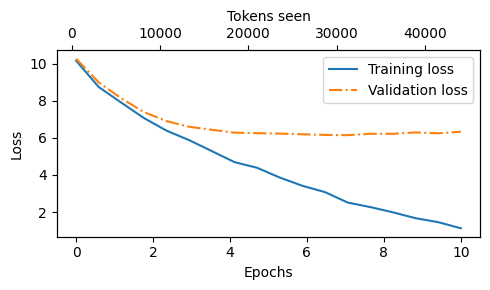

In [110]:
import matplotlib.pyplot as plt      #导入画图的库
from matplotlib.ticker import MaxNLocator # 用于将坐标限制为整数


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))  #创建一个5x3的画布，主坐标轴为ax1

    # 打印每一轮的训练损失和验证损失
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")   #在右上角添加图例
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  #x轴标签只显示整数

    #   再创建一个x轴x2（给token_seen）
    ax2 = ax1.twiny()  # 创建一个与x1共享y轴的x2
    ax2.plot(tokens_seen, train_losses, alpha=0)  #将第二个坐标轴的y轴坐标隐藏
    ax2.set_xlabel("Tokens seen") #添加x轴标签

    fig.tight_layout()  #调整布局，使图线不重合
    plt.savefig("loss-plot.pdf") #保存图片
    plt.show() #绘制出图片

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses)) #创建训练次数的向量，从0到num_epochs，共有len(train_losses)个点
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 相对于官方的代码，我这里降低了学习率..因为在本机上发生了梯度爆炸的问题。
- 随着训练的进行，出现了过拟合的现象（指的是在训练集上作用良好，但是在校验集上表现不佳），这是因为现在只是模型“记住”了当前的所有训练序列。
- 后续会有一些解码策略，来避免这种过拟合现象的发生
- 这里的过拟合现象是因为我们训练集合非常小，重复迭代了多次（出于学习考虑）

## 3.使用解码策略来控制随机性

- 在使用模型进行推理的阶段，（尤其是小模型）对计算性能的要求远不及训练的时候，所以不一定需要使用到gpu，大部分时候cpu就满足了。
- 这里再次使用5.1.2中的简单产生文本函数，这个函数是根据当前字典中最大概率对应的token生成的

In [86]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the picture for nothing--I told Mrs.

"I was no--and I was to


- 重复执行上面的代码，模型最后生成的都是同样的输出
- 接下来引入两个概念（解码策略），来使得上面的输出文本函数能随机，多样地进行生成
- 分为：temperature scaling 和 top-k sampling

### 3.1 Temperature scaling
- 先前我们使用torch.argmax函数来获得最高概率对应的值来作为下一个token
- 可以使用` torch.multionmial(probs,num_samples=1)` 来进行采样。它依赖于概率分布，概率越高越有可能被采集到，而不总只是最高值
  <br>

- 对先前写的产生下一个token的函数进行复习:

In [92]:
vocab = {          #词典表
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}  #反向词典表

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0) #将模型处理后获得的张量归一化，获得概率分布
next_token_id = torch.argmax(probas).item()  #直接获取概率最大值所对应的元素

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [100]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item() #采用 multionmial 方法来获得下一个词的token id
print(inverse_vocab[next_token_id])

toward


- 使用 multinomial函数来对概率分布进行抽样，能获取更多可能的结果，而不仅是最大值
- 下面进行1000次采样，来更直观地说明作用。

In [103]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)] #进行multinomal 1000次，并存放到一个列表中
    sampled_ids = torch.bincount(torch.tensor(sample))# 用于计算每个元素出现的次数
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


- 我们可以通过“温度缩放” 来控制概率分布和选择程序
- 温度缩放就是指的将logits除以一个大于0的数值
- 当温度大于1的时候，将数据平滑，使得能够更好取到概率低的数值
- 当温度小于1的时候，加强数据，使得一些数据概率更高，更容易获得

In [106]:
def softmax_with_temperature(logits,temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits,dim=0) #利用温度对logits进行处理

temperatures = [1,0.1,5] #设定温度的值--起始值，加强概率，减弱概率

#计算 缩放 后的概率
scaled_probas = [softmax_with_temperature(next_token_logits,T) for T in temperatures]

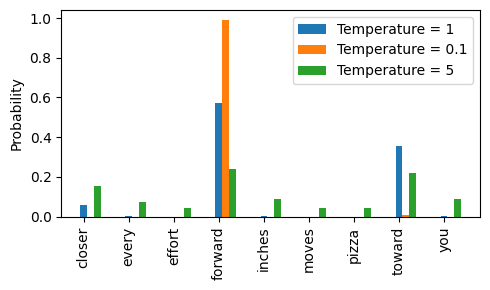

In [116]:
#绘制图表
x = torch.arange(len(vocab))
bar_width = 0.15
fig,ax = plt.subplots(figsize=(5,3)) #设置图表大小
for i,T in enumerate(temperatures):  #进行遍历，用于后续绘制
    rects = ax.bar(x+i*bar_width,scaled_probas[i],bar_width,label=f"Temperature = {T}")

ax.set_ylabel('Probability') #y轴坐标标签
ax.set_xticks(x) #x轴刻度位置
ax.set_xticklabels(vocab.keys(), rotation=90) #x轴刻度位置上填充关键字，并进行旋转90°
ax.legend() #添加图例

plt.tight_layout() #紧凑化
plt.savefig("temperature-plot.pdf")
plt.show()

- 通过0.1的温度进行处理，结果接近torch.argmax函数产生的结果

In [119]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward


In [121]:
print_sampled_tokens(scaled_probas[2]) #而通过5温度处理使得低概率的分布也更容易被选择

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


### 3.2 Top-k 抽样

- 为了能够获得多种高温度的词元，并且尽可能避免无异议语句出现的可能 -- 限制每次采样只选择前k 个数据

In [126]:
top_k = 3
top_logits,top_pos = torch.topk(next_token_logits,top_k) #获取前top_k个数据 和他们的索引

print("Top logits:",top_logits)
print("Top positions:",top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [128]:
new_logits = torch.where(
    condition = next_token_logits < top_logits[-1] , # 判断当前的单词是否小于topk中的最低概率
    input = torch.tensor(float("-inf")) , #输入负无穷
    other = next_token_logits #否则就是它本身
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [132]:
#另一种实现方式
new_logits = torch.full_like(
    next_token_logits,-torch.inf  #构造一个大小和next_token_logits相同的张量，值全部填充为-inf
)
new_logits[top_pos] = next_token_logits[top_pos]  #将top_k概率所在的位置赋值
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [134]:
topk_probas = torch.softmax(new_logits,dim=0) #将进行采样过后的数据进行归一化
print(topk_probas) 

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 3.3 修改文本生成函数

In [26]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens): #每次生成一个词，循环max_new_tokens 次
        idx_cond = idx[:, -context_size:] #提取文本的最后 context_size 个数据
        with torch.no_grad(): #生成文本，不需要影响梯度（类似于叫校验的时候）
            logits = model(idx_cond) #将数据通过模型，获得logits
        logits = logits[:, -1, :] #只考虑最后一个数据的logits，用于生成它的下一个单词  形状 （batch_size, num_tokens, vocab） --> (batch_size,vocab_size)
        #抽取三维向量中的一个，转化为二维。
        
        # New: Filter logits with top_k sampling 利用topk采样来过滤 filter
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)
            #如果当前的logits 小于 最小topk概率 ，则将其改为-inf（传输到当前设备上）

        # New: Apply temperature scaling 应用温度缩放
        if temperature > 0.0: #温度必须为正数
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, vocab_size) 

            # Sample from the distribution 获取下一个token的id
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else: #如果没有设置温度，则按先前的方法，返回最高概率的id
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break #指定了结束id的情况

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1) #将新生成的文本加入原先的文本

    return idx

In [139]:
torch.manual_seed(123)

token_ids = generate(  #利用新设置的函数生成文本
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my with a picture for it was no
"; and


## 4. 在pytorch 中保存和加载模型权重
- LLM的训练成本很高，所以要考虑到保存和加载已训练过的权重数据
- 最推荐的方法是 `state_dict` ,利用torch.save函数

In [142]:
torch.save(model.state_dict(),"model.pth") #将模型的数据保存在model.pth文件中

- 加载一个模型权重

In [20]:
model = GPTModel(GPT_CONFIG_124M) #实例化一个新的模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #设定当前的设备
model.load_state_dict(torch.load("model.pth",map_location = device,weights_only = True)) #加载model.pth中的数据，加载到当前设备上，只加载权重

<All keys matched successfully>

- 通常使用Adam/AdamW 优化器进行模型训练
- 保存的时候加上这些优化器，方便在下一次提取出模型权重的时候，还能继续再进行预训练

In [149]:
torch.save(
    {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict":optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [151]:
checkpoint = torch.load("model_and_optimizer.pth",weights_only = True) #加载刚刚保存的数据，用于检查

model = GPTModel(GPT_CONFIG_124M) #实例化一个新模型
model.load_state_dict(checkpoint["model_state_dict"]) #加载模型权重

optimizer = torch.optim.AdamW(model.parameters(),lr = 0.0005,weight_decay=0.1) #生成一个新优化器
optimizer.load_state_dict(checkpoint["optimizer_state_dict"]) #加载刚刚保存拿到优化器
model.train() 

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## 5.从OpenAI 中加载预训练权重

- 需要先从openai 下载文件并将权重数据导入python
- 因为openai使用[TensorFlow](https://www.tensorflow.org/) ，我们需要下载这个库来加载权重。
- 使用[tqdm](https://github.com/tqdm/tqdm)（先进的进度条加载库）

In [12]:
#pip install tensorflow tqdm

In [8]:
print("TensorFlow vesion:",version("tensorflow"))
print("tqdm version:",version("tqdm"))

TensorFlow vesion: 2.17.0
tqdm version: 4.66.5


In [14]:
from gpt_download import download_and_load_gpt2

In [16]:
# 下载124M的参数模型权重
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")


File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [3]:
print("Settings:",settings)
print("Parameter dictionary keys:",params.keys())
print(params["wte"])
print("Token embedding weight tensor dimensions:",params["wte"].shape)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- 模型也可以选择355M，774M，1558M的参数。
- 这些导致参数大小区别的因素：嵌入向量的维度，transformer block 循环的次数，多注意力的head数。
<br>

- 原始的GPT模型使用了不推荐的偏置相，这里为了载入正确的权重矩阵，就需要同样将偏置相设置为True

In [4]:
# Define model configurations in a dictionary for compactness  
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy() #拷贝配置
NEW_CONFIG.update(model_configs[model_name]) #加入配置
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True}) #加入配置

gpt = GPTModel(NEW_CONFIG) #实例化一个gpt实例
gpt.eval(); #切换为评估模式

- 将openai提供的权重分配到我们的gpt模型中

In [8]:
def assign(left, right): #定义一个重新分配的函数
    if left.shape != right.shape:  #如果两边的形状不相同
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}") #返回错误，指出两个向量形状不相同
    return torch.nn.Parameter(torch.tensor(right)) #否则返回right包装后的张量（可以后续再进行优化的类型parameter）

In [22]:
import numpy as np

def load_weights_into_gpt(gpt,params): #将权重加载进gpt模型中
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight,params['wpe']) #载入位置嵌入层的权重
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight,params['wte']) #载入token嵌入层的权重

    for b in range(len(params["blocks"])): #循环遍历每一层
        q_w, k_w, v_w = np.split(  #从给定参数中分离出query,key,value 的权重 ，按列分为3个部分。
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(  #并将这三个权重依次重新分配到gpt模型中
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(   #从给定参数中分离出query,key,value 的偏置
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)  
        gpt.trf_blocks[b].att.W_query.bias = assign(  #并将它们依次分配到gpt模型中
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(  #提取 c_proj 的输出权重和偏置，并赋给注意力层的输出投影
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign( #将mlp（Multilayer Perceptron）层第一层权重和偏置传入
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(  #将mlp层的输出投影层权重和偏置传入
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(   #传入第一个层归一化（LayerNorm）的缩放和偏移
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(  #传入第二个层归一化的缩放和偏移
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])  #载入输出层的缩放和偏移
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"]) #词嵌入的权重再次用于输出层的权重
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);        

In [32]:
#模型参数已经传入后，利用该模型再次生成文本

torch.manual_seed(123)

token_ids = generate(  
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the
